In [4]:
%load_ext autoreload
%autoreload 1

from pathlib import Path

import numpy as np
import safetensors
from sklearn.decomposition import PCA

from matplotlib import pyplot as plt

from prelib import data_dir
%aimport e6db.utils
from e6db.utils import load_tags

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [11]:
with safetensors.safe_open(data_dir / 'implicit_tag_factors.safetensors', framework='numpy') as st:
    X0 = st.get_tensor('tag_factors')

tags2id, tags = load_tags(data_dir)
tags = np.array(tags)

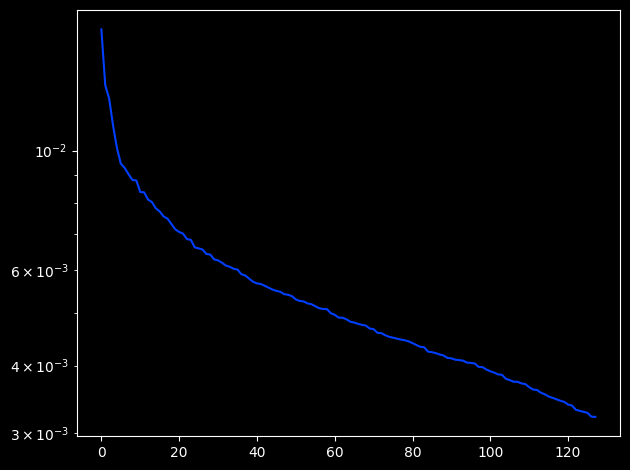

In [75]:
X = X0.copy()
# You might want to play with normalization, ie disabling these:
X /= np.linalg.norm(X, axis=1)[:, None]

# A first rank truncation using PCA helps smooth the noise
pca = PCA(128)
Xt = pca.fit_transform(X)
Xt /= np.linalg.norm(Xt, axis=1)[:, None] # <- same here

plt.semilogy(pca.explained_variance_)

In [76]:
#sel_tags = ['bodily_fluids', 'genital_fluids', 'cum', 'precum', 'sweat', 'urine', 'tears', 'tears', 'blood']
sel_tags = ['trio', 'trio_focus', 'duo', 'duo_focus', 'solo', 'solo_focus', 'threesome', 'foursome']

sel_idxs = [tags2id[t] for t in sel_tags if t in tags2id]
sel_idxs.sort()
sel_tags = [tags[i] for i in sel_idxs]
print(' '.join(sel_tags))

solo duo solo_focus trio threesome duo_focus foursome trio_focus


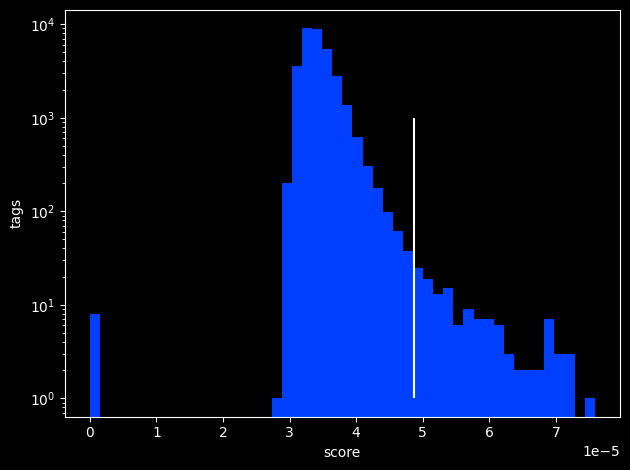

In [201]:
# Select neighboring tags similar to foreground one
n_neighbors = 128
n_neighbors_display = 32
temp = 1
# We can pick tags that are the close to all the input tags simultaneously, or close to the closest input tag
lp = 8 # This is done with lp-norm: p=1: sum of probabilities, p->inf: max

neigh_score = Xt @ Xt[sel_idxs].T


neigh_score = Xt @ Xt[sel_idxs].T
neigh_score[sel_idxs, :] = float('-inf')
neigh_score = np.exp(neigh_score / temp)
neigh_score /= neigh_score.sum(axis=0)
if lp >= 8:
    neigh_score = neigh_score.max(axis=1)
else:
    neigh_score = (neigh_score ** lp).sum(axis=1) ** (1/lp)

neigh_idxs = np.argsort(neigh_score)[::-1][:n_neighbors]

plt.hist(neigh_score, 50, log=True);
plt.vlines(neigh_score[neigh_idxs[-1]], 1, 1e3)
plt.ylabel('tags')
plt.xlabel('score')
del neigh_score

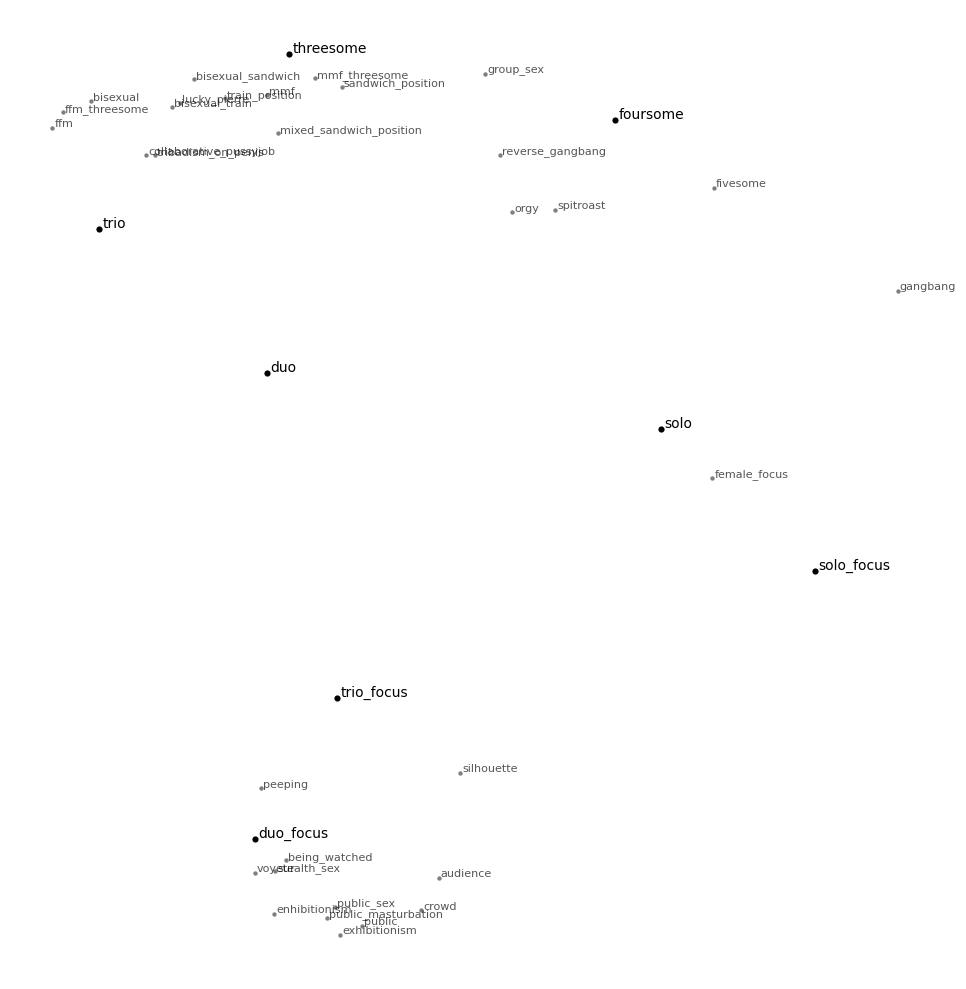

In [202]:
idxs = np.concatenate([sel_idxs, neigh_idxs])

# Local PCA
X2 = Xt[idxs].copy()
X2 /= np.linalg.norm(X2, axis=1)[:, None]
X2 -= X2.mean(0)
X2 /= np.linalg.norm(X2, axis=1)[:, None]
X2t = PCA(2).fit_transform(X2)[:,::-1]

dark_mode = False
fg_color = 'white' if dark_mode else 'black'
bg_color = 'black' if dark_mode else 'white'

f, ax = plt.subplots(figsize=(10,10))
ax.axis('off')
f.set_facecolor(bg_color)

dx = 0.01
ax.scatter(*X2t[:len(sel_idxs)].T, 
           c=fg_color, linewidth=0, s=20)
for i, t in enumerate(sel_tags):
    ax.annotate(t, tuple(X2t[i,:] + [dx*0.5, dx*0.25]), 
                color=fg_color)

ax.scatter(*X2t[len(sel_idxs):len(sel_idxs) + n_neighbors_display].T, 
           c=fg_color, linewidth=0, s=10, alpha=0.5)
for i, t in enumerate(tags[neigh_idxs[:n_neighbors_display]], len(sel_idxs)):
    ax.annotate(t, tuple(X2t[i,:] + [dx*0.3, dx*0.3/2]), 
                color=fg_color, fontsize=8, alpha=2/3)

f.tight_layout()